In [505]:

import os, cv2, random
import numpy as np
import pandas as pd
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import roc_auc_score, r2_score, accuracy_score, roc_curve, auc

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from matplotlib import style
style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')


Populating the interactive namespace from numpy and matplotlib


### Look on images description

In results.csv is image description file, Where for each image we can see it gender 0 or 1. 

0 - male

1 - female

In [506]:
# Load All file
imgFilesDir = "./final/"
data = pd.read_csv('results.csv')
data.head()

,Filename,Gender,Age
0,Raw_0001_001_20050913115022_Portrait.png,1,1
1,Raw_0002_002_20050913094354_Portrait.png,1,1
2,Raw_0003_003_20050913094955_Portrait.png,0,0
3,Raw_0005_004_20050913101316_Portrait.png,1,1
4,Raw_0007_005_20050913093707_Portrait.png,0,1


In [507]:
# loading labels for each image from csv
data = pd.read_csv('results.csv')
labels = data.iloc[:,0:2]

### Male images

In [508]:

# Separating male labels
male_data = labels[labels['Gender'] == 0]
male_data.head()

,Filename,Gender
2,Raw_0003_003_20050913094955_Portrait.png,0
4,Raw_0007_005_20050913093707_Portrait.png,0
5,Raw_0009_006_20050913122608_Portrait.png,0
6,Raw_0010_007_20050913094809_Portrait.png,0
7,Raw_0011_008_20050913123954_Portrait.png,0


### Female images

In [509]:
# Separating female labels
female_data = labels[labels['Gender'] == 1]
female_data.head()

,Filename,Gender
0,Raw_0001_001_20050913115022_Portrait.png,1
1,Raw_0002_002_20050913094354_Portrait.png,1
3,Raw_0005_004_20050913101316_Portrait.png,1
9,Raw_0014_010_20050913093018_Portrait.png,1
22,Raw_0039_023_20050913110844_Portrait.png,1


In [510]:
print("Female dataset shape: " + str(female_data.shape))
print("Male dataset shape: " + str(male_data.shape))

Female dataset shape: (32, 2)
Male dataset shape: (84, 2)


In [511]:
### Select number of images to test datat set for botj male and femele sets.
nToTest = 10

In [512]:

# Splitting male data into train and test
test_female_data = female_data.iloc[-nToTest:,:]
train_female_data = female_data.iloc[:-nToTest,:]

### Let`s look on some images from amle and female datatset

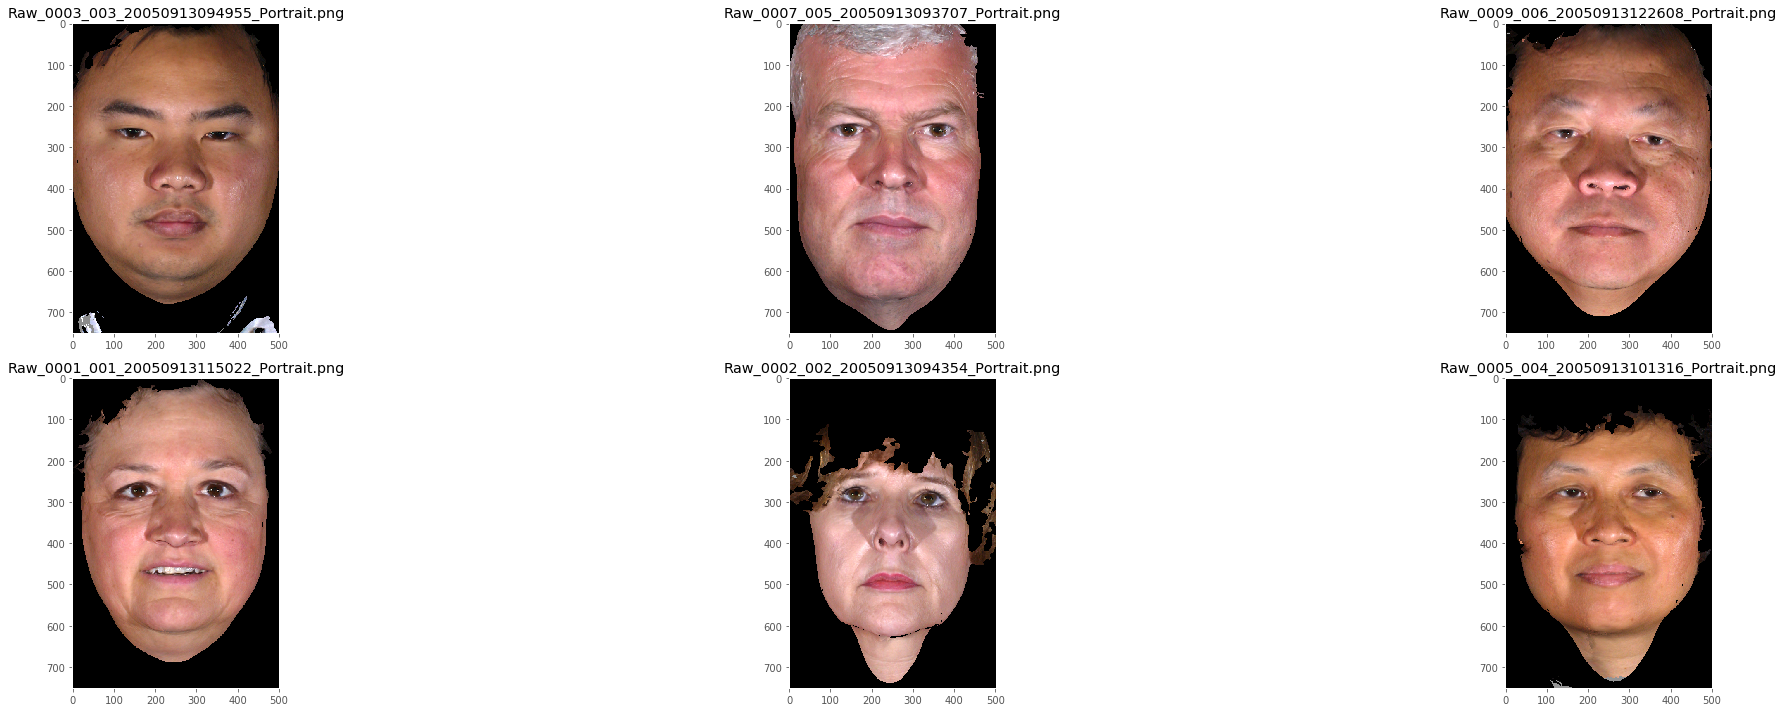

In [513]:
num_rows = 2
num_cols = 3
num_images = num_rows*num_cols
imagesToPlot = male_data.Filename.iloc[:3].tolist() +  female_data.Filename.iloc[:3].tolist()
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i,img in enumerate(imagesToPlot):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    imag=mpimg.imread(imgFilesDir + img)
    plt.imshow(imag)
    plt.title(img)
    plt.grid(False)
plt.tight_layout()
plt.show()

### Combinae test data set

In [514]:
# total test data
test_indices = test_female_data.index.tolist() + test_male_data.index.tolist()
test_data = labels.iloc[test_indices,:]
test_data.head()

,Filename,Gender
90,Raw_0173_091_20050913111053_Portrait.png,1
91,Raw_0175_092_20050913100355_Portrait.png,1
92,Raw_0177_093_20050913110014_Portrait.png,1
93,Raw_0179_094_20050913095613_Portrait.png,1
95,Raw_0246_096_20050912173029_Portrait.png,1


### Combine train datat set

In [515]:

# total train data
train_data = pd.concat([labels, test_data, test_data]).drop_duplicates(keep=False)
train_data.head()

,Filename,Gender
0,Raw_0001_001_20050913115022_Portrait.png,1
1,Raw_0002_002_20050913094354_Portrait.png,1
2,Raw_0003_003_20050913094955_Portrait.png,0
3,Raw_0005_004_20050913101316_Portrait.png,1
4,Raw_0007_005_20050913093707_Portrait.png,0


### Let`s look on 'Gender' distribution in whole data set

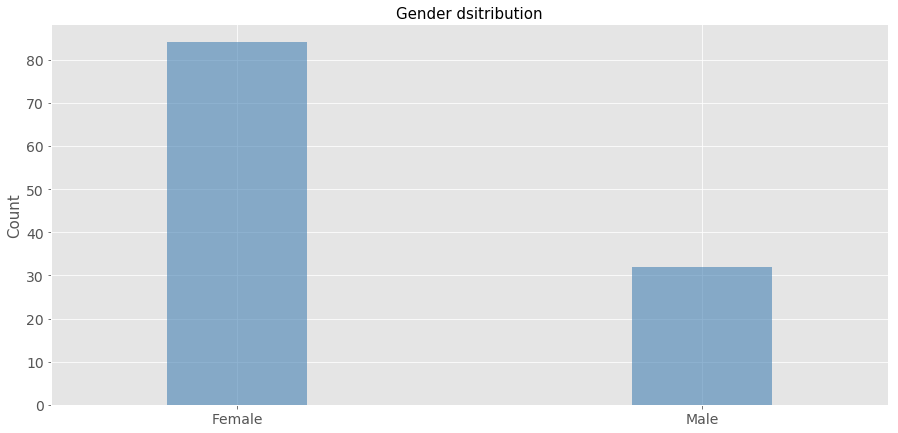

In [516]:
dd = data.copy()
dd["Gender2"] = np.where(data.Gender==1, "Female", "Male")
f = plt.figure(figsize=(15, 7))
ax = f.add_subplot(111)
dd.Gender2.value_counts().plot(kind='bar', color="steelblue", alpha=0.6, width=0.3, fontsize=13)
ax.set_xticklabels(dd.Gender2.unique(),rotation=0, fontsize=11)
ax.set_title("Gender dsitribution", size=15)
ax.set_ylabel("Count", size=15)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

In [517]:

# train and test with image name along with paths
path = './final/' # path of your image folder
train_image_name = [path+each for each in train_data['Filename'].values.tolist()]
test_image_name = [path+each for each in test_data['Filename'].values.tolist()]


# lets take first image and check it shape
imag = mpimg.imread(imgFilesDir + imagesToPlot[0])
print("Image shape: " + str(imag.shape))

Image shape: (751, 501, 3)


### Reshape image size to 64x64

**Reshape to (I, C, H, W)**
*    I: Images count
*    C: Color channels: 1-GtayScale, 3-RGB
*    H: Height of image in pixels
*    W: Width Image in pixels


In [518]:

# preparing data by processing images using opencv

ROWS = 64
COLS = 64
CHANNELS = 3

# We scale these values to a range of 0 to 1 before feeding them to the neural network. To do this, we will divide the values by 255. It is important that the training set and the test set are pre-processed equally

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    img = img / 255.0
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.float32)
    #data = np.ndarray((count, COLS,  ROWS, CHANNELS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        #if i%5 == 0: 
        #    print('Processed {} of {}'.format(i, count))
    
    return data

trainData = prep_data(train_image_name)
testData = prep_data(test_image_name)

#trainData /= 255
#testData /= 255

In [519]:
trainLabs = train_data.iloc[:,1].values.tolist()
testLabs = test_data.iloc[:,1].values.tolist()

print("Train shape: " + str(trainData.shape))
print("Test shape: " + str(testData.shape))

Train shape: (103, 3, 64, 64)
Test shape: (13, 3, 64, 64)


In [520]:
trainData[0].max(axis=1).max()

1.0004475

### Plotting female and male side by side

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


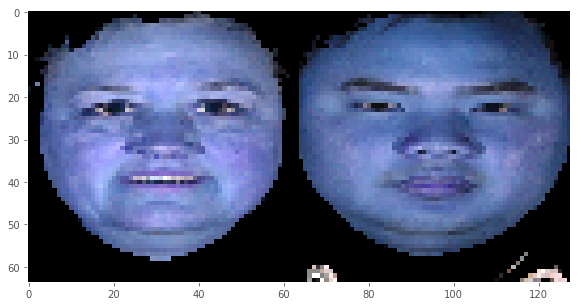

In [521]:

# plotting female and male side by side
def show_male_and_female():
    female = read_image(train_image_name[0])
    male = read_image(train_image_name[2])
    pair = np.concatenate((female, male), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.grid(False)
    plt.show()
    
show_male_and_female()

In [522]:
# splitting path of all images into male and female
train_male_image = []
train_female_image = []
for each in train_image_name:
    if each.split('/')[-1] in train_male_data['Filename'].values:
        train_male_image.append(each)
    else:
        train_female_image.append(each)

<hr>

### Let`s build NN with convolution, maxPoll and droput layers
* Set Early stop
* Set directory for best model to auto save
* loss = binary_crossentropy
* min_delta=0.0001
* Convolution kernel_size = 3x3
* MaxPolling pool_size = 2x2
* Dropout = 0.25

In [523]:

batch_size = 5
patience = 10
epochs = 30
min_delta = 0.0001
dropout = 0.25

model_name = 'keras_gender_conv.h5'
save_dir = "./models/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, ROWS, COLS), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))
model.add(Dropout(dropout))

model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))
model.add(Dropout(dropout))

model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))
model.add(Dropout(dropout))

model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))
model.add(Dropout(dropout))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))


# compiling the sequential model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model and saving metrics in history
history = model.fit(trainData, trainLabs,
          batch_size=batch_size, epochs=epochs,
          verbose=2,
          validation_data=(testData, testLabs),
          callbacks=[
            ModelCheckpoint(model_path, save_best_only=True),
            EarlyStopping(monitor='val_loss', mode='min', patience=patience, min_delta=min_delta, verbose=2)
          ])

Train on 103 samples, validate on 13 samples
Epoch 1/30
 - 2s - loss: 0.8960 - accuracy: 0.5049 - val_loss: 0.9498 - val_accuracy: 0.2308
Epoch 2/30
 - 1s - loss: 0.6477 - accuracy: 0.6505 - val_loss: 0.4690 - val_accuracy: 0.7692
Epoch 3/30
 - 1s - loss: 0.6272 - accuracy: 0.6214 - val_loss: 0.6675 - val_accuracy: 0.7692
Epoch 4/30
 - 1s - loss: 0.4470 - accuracy: 0.7864 - val_loss: 0.2826 - val_accuracy: 0.9231
Epoch 5/30
 - 1s - loss: 0.5287 - accuracy: 0.7767 - val_loss: 1.1740 - val_accuracy: 0.2308
Epoch 6/30
 - 1s - loss: 0.3737 - accuracy: 0.8544 - val_loss: 0.5688 - val_accuracy: 0.6923
Epoch 7/30
 - 1s - loss: 0.3347 - accuracy: 0.8738 - val_loss: 0.3349 - val_accuracy: 0.7692
Epoch 8/30
 - 1s - loss: 0.2719 - accuracy: 0.8835 - val_loss: 0.3398 - val_accuracy: 0.7692
Epoch 9/30
 - 1s - loss: 0.3365 - accuracy: 0.8155 - val_loss: 0.8103 - val_accuracy: 0.6154
Epoch 10/30
 - 1s - loss: 0.3403 - accuracy: 0.8447 - val_loss: 1.2758 - val_accuracy: 0.2308
Epoch 11/30
 - 1s - loss

### Convolution Nn results

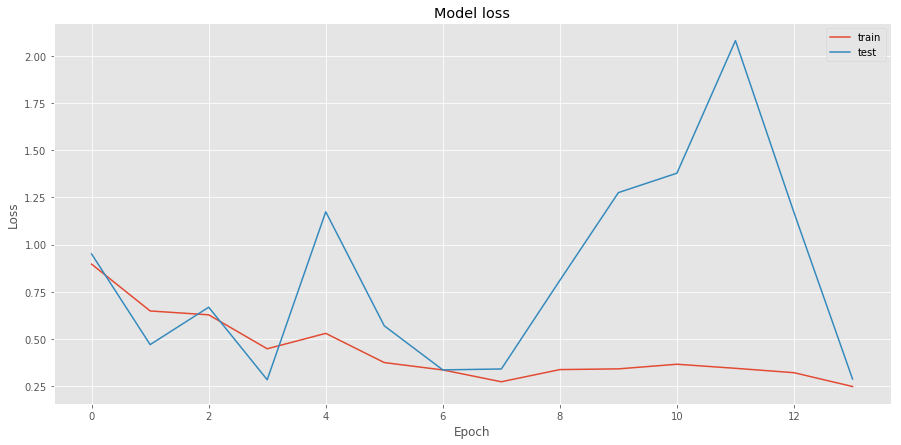

In [524]:
# plotting the metrics
fig = plt.figure(figsize=(15,7))
ax = plt.subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Model loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['train', 'test'], loc='upper right')
ax.grid(True)

plt.show()

In [525]:
predictions = model.predict(testData, verbose=0)

In [526]:
roc_auc = roc_auc_score(testLabs, predictions)
print("ROC AUC: " +  str(roc_auc))

ROC AUC: 1.0


In [527]:
acc_thresh = 0.6
print("Accuracy treshold = " + str(acc_thresh))
actual = testLabs
predicted = [0 if x<acc_thresh else 1 for x in  predictions]

results = confusion_matrix(actual, predicted) 
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(actual, predicted) )
print ('Report : ')
print (classification_report(actual, predicted))


Accuracy treshold = 0.6
Confusion Matrix :
[[ 1  2]
 [ 0 10]]
Accuracy Score : 0.8461538461538461
Report : 
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.83      1.00      0.91        10

    accuracy                           0.85        13
   macro avg       0.92      0.67      0.70        13
weighted avg       0.87      0.85      0.81        13



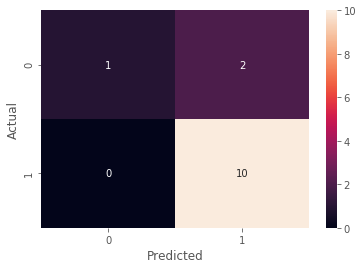

In [528]:
confusionМx = pd.crosstab(np.array(testLabs), np.array(predicted), rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusionМx, annot=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 99.99% sure this is a Female


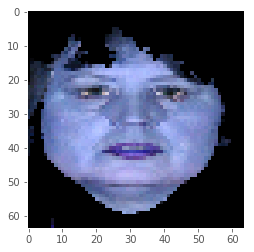

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 99.98% sure this is a Female


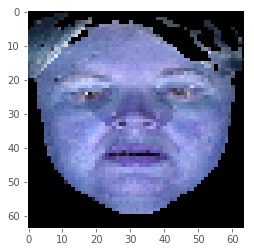

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 99.47% sure this is a Female


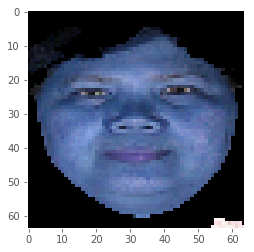

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 99.97% sure this is a Female


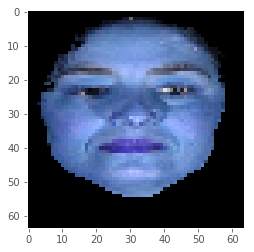

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 97.64% sure this is a Female


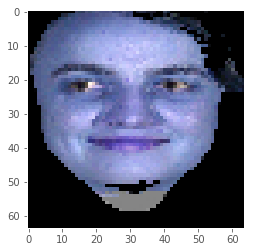

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 83.47% sure this is a Female


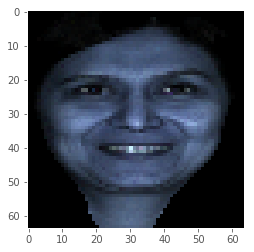

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 99.92% sure this is a Female


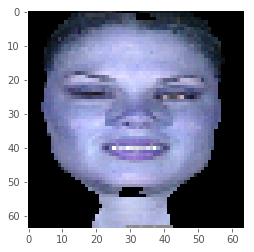

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 99.96% sure this is a Female


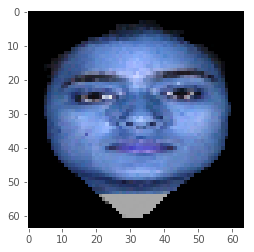

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 81.38% sure this is a Female


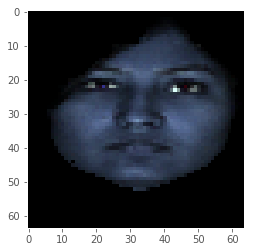

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 98.55% sure this is a Female


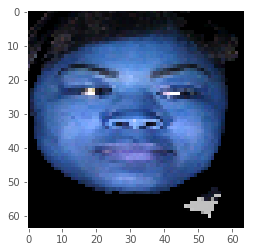

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 80.10% sure this is a Female


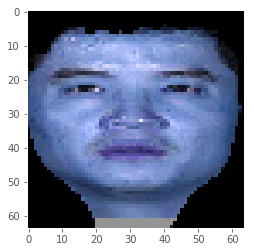

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 88.29% sure this is a Male


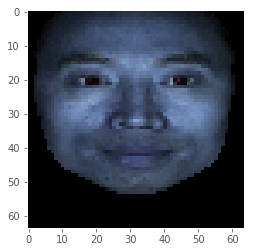

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 78.88% sure this is a Female


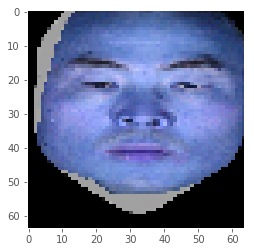

In [529]:

for i in range(0,min(20, len(predictions))):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Female'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Male'.format(1-predictions[i][0]))
        
    plt.imshow(testData[i].T)
    plt.grid(False)
    plt.show()

<hr>

### Let`s build DNN
* Set Early stop
* Set directory for best model to auto save
* loss = binary_crossentropy
* min_delta=0.0001
* Dropout = 0.25

In [530]:
batch_size = 5
patience = 10
epochs = 30
min_delta = 0.0001
dropout = 0.25

input_shape_dnn = ROWS * COLS *CHANNELS
trainDataDnn = trainData.reshape(trainData.shape[0], input_shape_dnn)
testDataDnn = testData.reshape(testData.shape[0], input_shape_dnn)

model_nameDnn = 'keras_gender_dnn.h5'
save_dir = "./models/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
model_pathDnn = os.path.join(save_dir, model_nameDnn)


modelDnn = Sequential()

modelDnn.add(Dense(256, input_shape=(input_shape_dnn,), activation='relu'))
model.add(Dropout(dropout))

modelDnn.add(Dense(256, activation='relu'))
modelDnn.add(Dropout(dropout))

modelDnn.add(Dense(1, activation='sigmoid'))


# compiling the sequential model
modelDnn.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model and saving metrics in history
historyDnn = modelDnn.fit(trainDataDnn, trainLabs,
          batch_size=batch_size, epochs=epochs,
          verbose=2,
          validation_data=(testDataDnn, testLabs),
          callbacks=[
            ModelCheckpoint(model_pathDnn, save_best_only=True),
            EarlyStopping(monitor='val_loss', mode='min', patience=patience, min_delta=min_delta, verbose=2)
          ])

Train on 103 samples, validate on 13 samples
Epoch 1/30
 - 2s - loss: 0.9062 - accuracy: 0.6990 - val_loss: 0.5150 - val_accuracy: 0.7692
Epoch 2/30
 - 1s - loss: 0.6656 - accuracy: 0.7961 - val_loss: 0.5276 - val_accuracy: 0.7692
Epoch 3/30
 - 1s - loss: 0.3626 - accuracy: 0.8932 - val_loss: 1.7178 - val_accuracy: 0.4615
Epoch 4/30
 - 1s - loss: 0.2661 - accuracy: 0.9126 - val_loss: 1.1463 - val_accuracy: 0.5385
Epoch 5/30
 - 1s - loss: 0.2251 - accuracy: 0.9029 - val_loss: 0.5871 - val_accuracy: 0.6923
Epoch 6/30
 - 1s - loss: 0.2551 - accuracy: 0.8932 - val_loss: 1.1342 - val_accuracy: 0.5385
Epoch 7/30
 - 1s - loss: 0.2217 - accuracy: 0.9029 - val_loss: 1.1512 - val_accuracy: 0.5385
Epoch 8/30
 - 1s - loss: 0.2354 - accuracy: 0.8932 - val_loss: 0.1884 - val_accuracy: 1.0000
Epoch 9/30
 - 1s - loss: 0.1867 - accuracy: 0.9223 - val_loss: 2.6500 - val_accuracy: 0.3846
Epoch 10/30
 - 1s - loss: 0.1662 - accuracy: 0.9515 - val_loss: 1.1068 - val_accuracy: 0.5385
Epoch 11/30
 - 1s - loss

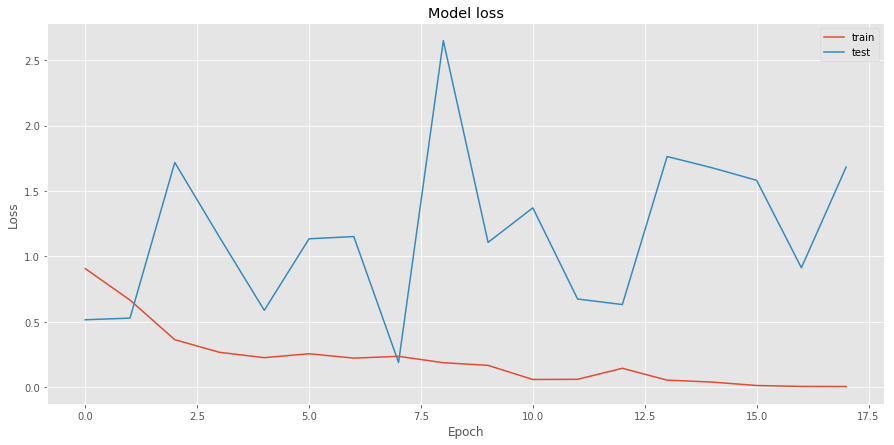

In [531]:
# plotting the metrics
fig = plt.figure(figsize=(15,7))
ax = plt.subplot(111)
ax.plot(historyDnn.history['loss'])
ax.plot(historyDnn.history['val_loss'])
ax.set_title('Model loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['train', 'test'], loc='upper right')
ax.grid(True)

plt.show()

In [532]:
predictionsDnn = modelDnn.predict(testDataDnn, verbose=0)

In [547]:
roc_auc_dnn = roc_auc_score(testLabs, predictionsDnn.ravel())
print("ROC AUC: " +  str(roc_auc))

ROC AUC: 1.0


In [549]:
 roc_auc_score([1,1,1,0], [0.6, 0.7, 0.8, 0.1])

1.0

In [545]:
np.array(testLabs)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0])

In [543]:
predictionsDnn.ravel().round(2)

array([0.99, 0.16, 0.57, 0.99, 0.  , 0.22, 0.02, 0.82, 0.82, 0.  , 0.  ,
       0.01, 0.  ], dtype=float32)

In [534]:
acc_thresh = 0.6
print("Accuracy treshold = " + str(acc_thresh))
actual = testLabs
predictedDnn = [0 if x<acc_thresh else 1 for x in  predictionsDnn]

resultsDnn = confusion_matrix(actual, predictedDnn) 
print ('Confusion Matrix :')
print(resultsDnn) 
print ('Accuracy Score :',accuracy_score(actual, predictedDnn) )
print ('Report : ')
print (classification_report(actual, predictedDnn))


Accuracy treshold = 0.6
Confusion Matrix :
[[3 0]
 [6 4]]
Accuracy Score : 0.5384615384615384
Report : 
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         3
           1       1.00      0.40      0.57        10

    accuracy                           0.54        13
   macro avg       0.67      0.70      0.54        13
weighted avg       0.85      0.54      0.55        13



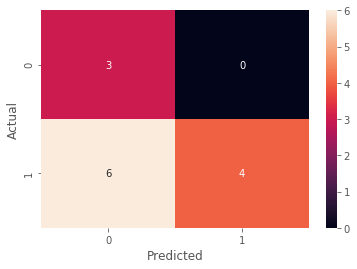

In [535]:
confusionМx = pd.crosstab(np.array(testLabs), np.array(predictedDnn), rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusionМx, annot=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 98.51% sure this is a Female


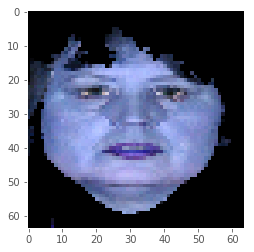

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 16.19% sure this is a Female


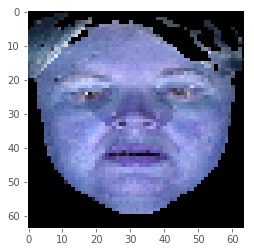

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 57.12% sure this is a Female


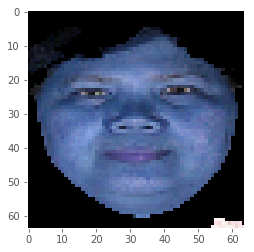

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 98.75% sure this is a Female


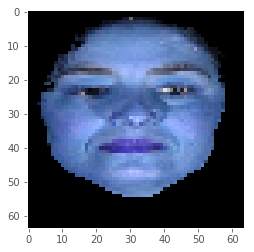

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 0.07% sure this is a Female


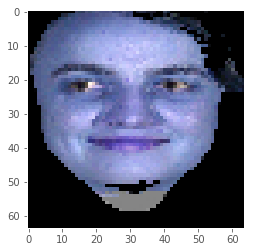

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 22.47% sure this is a Female


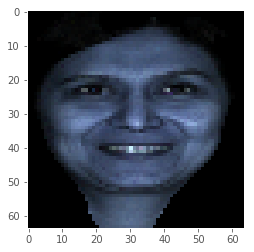

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 2.02% sure this is a Female


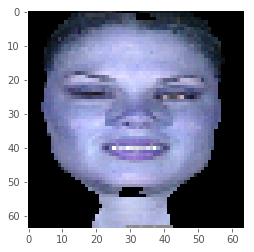

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 81.51% sure this is a Female


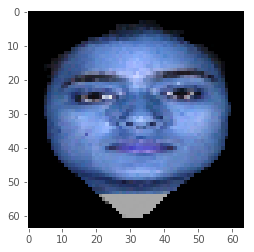

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 81.74% sure this is a Female


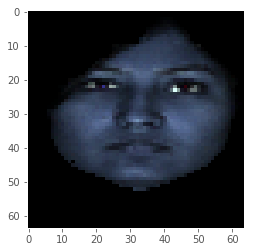

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 0.17% sure this is a Female


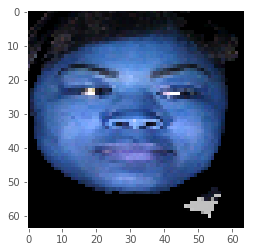

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 0.00% sure this is a Female


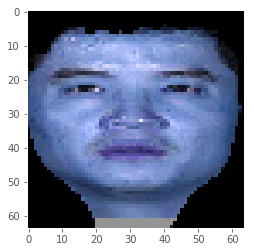

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 99.46% sure this is a Male


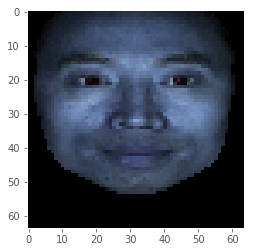

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 0.00% sure this is a Female


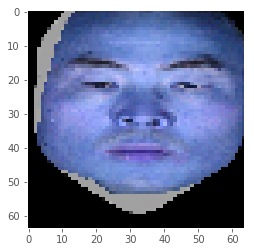

In [536]:

for i in range(0,min(20, len(predictionsDnn))):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Female'.format(predictionsDnn[i][0]))
    else: 
        print('I am {:.2%} sure this is a Male'.format(1-predictionsDnn[i][0]))
        
    plt.imshow(testData[i].T)
    plt.grid(False)
    plt.show()